# Generate data

In [1]:
import os, time, pickle, random, time, sys, math
from datetime import datetime
import numpy as np
from time import localtime, strftime
import logging, scipy
import hickle as hkl
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6"
import tensorflow as tf
import tensorlayer as tl
from tensorlayer.layers import *
import matplotlib.pyplot as plt

In [2]:
#GPU setting and Global parameters

checkpoint = "checkpoint_easy"
log_dir = "log_easy"
save_dir_gan = "samples"
tl.global_flag['mode']='hicgan'
tl.files.exists_or_mkdir(checkpoint)
tl.files.exists_or_mkdir(save_dir_gan)
tl.files.exists_or_mkdir(log_dir)
batch_size = 16
lr_init = 1e-4
beta1 = 0.9
## initialize G
#n_epoch_init = 100
n_epoch_init = 10
n_epoch = 100
lr_decay = 0.1
decay_every = int(n_epoch / 2)
ni = int(np.sqrt(batch_size))

[TL] [!] checkpoint_easy exists ...


True

[TL] [!] samples exists ...


True

[TL] [!] log_easy exists ...


True

In [5]:
#Data preparation and preprocessing
def hic_matrix_extraction(DPATH,res=10000,norm_method='NONE'):
    chrom_list = list(range(1,23))#chr1-chr22
    hr_contacts_dict={}
    for each in chrom_list:
        hr_hic_file = '%s/intra_%s/chr%d_10k_intra_%s.txt'%(DPATH,norm_method,each,norm_method)
        chrom_len = {item.split()[0]:int(item.strip().split()[1]) for item in open('%s/chromosome.txt'%DPATH).readlines()}
        mat_dim = int(math.ceil(chrom_len['chr%d'%each]*1.0/res))
        hr_contact_matrix = np.zeros((mat_dim,mat_dim))
        for line in open(hr_hic_file).readlines():
            idx1, idx2, value = int(line.strip().split('\t')[0]),int(line.strip().split('\t')[1]),float(line.strip().split('\t')[2])
            hr_contact_matrix[idx1/res][idx2/res] = value
        hr_contact_matrix+= hr_contact_matrix.T - np.diag(hr_contact_matrix.diagonal())
        hr_contacts_dict['chr%d'%each] = hr_contact_matrix
    lr_contacts_dict={}
    for each in chrom_list:
        lr_hic_file = '%s/intra_%s/chr%d_10k_intra_%s_downsample_ratio16.txt'%(DPATH,norm_method,each,norm_method)
        chrom_len = {item.split()[0]:int(item.strip().split()[1]) for item in open('%s/chromosome.txt'%DPATH).readlines()}
        mat_dim = int(math.ceil(chrom_len['chr%d'%each]*1.0/res))
        lr_contact_matrix = np.zeros((mat_dim,mat_dim))
        for line in open(lr_hic_file).readlines():
            idx1, idx2, value = int(line.strip().split('\t')[0]),int(line.strip().split('\t')[1]),float(line.strip().split('\t')[2])
            lr_contact_matrix[idx1/res][idx2/res] = value
        lr_contact_matrix+= lr_contact_matrix.T - np.diag(lr_contact_matrix.diagonal())
        lr_contacts_dict['chr%d'%each] = lr_contact_matrix

    nb_hr_contacts={item:sum(sum(hr_contacts_dict[item])) for item in hr_contacts_dict.keys()}
    nb_lr_contacts={item:sum(sum(lr_contacts_dict[item])) for item in lr_contacts_dict.keys()}
    max_hr_contact = max([nb_hr_contacts[item] for item in nb_hr_contacts.keys()])
    max_lr_contact = max([nb_lr_contacts[item] for item in nb_lr_contacts.keys()])
    
    return hr_contacts_dict,lr_contacts_dict,max_hr_contact,max_lr_contact

In [6]:
hr_contacts_dict,lr_contacts_dict,max_hr_contact,max_lr_contact = hic_matrix_extraction('/home/liuqiao/software/HiCPlus/data/GM12878_primary/aligned_read_pairs')

In [7]:
hr_contacts_norm_dict = {item:np.log2(hr_contacts_dict[item]*max_hr_contact/sum(sum(hr_contacts_dict[item]))+1) for item in hr_contacts_dict.keys()}
lr_contacts_norm_dict = {item:np.log2(lr_contacts_dict[item]*max_lr_contact/sum(sum(lr_contacts_dict[item]))+1) for item in lr_contacts_dict.keys()}

In [8]:
max_hr_contact_norm={item:hr_contacts_norm_dict[item].max() for item in hr_contacts_dict.keys()}
max_lr_contact_norm={item:lr_contacts_norm_dict[item].max() for item in lr_contacts_dict.keys()}

In [23]:
#Data preparation and preprocessing for hicgan
def crop_hic_matrix_by_chrom(chrom, size=40 ,thred=200):
    #thred=2M/resolution
    def hic_normlize(mat):
        row,col = mat.shape
        mat_trans = np.log2(mat*max_contact/sum(sum(mat))+1)
        mat_trans /=0.5*mat_trans.max()
        mat_trans-=1
        return mat_trans
    crop_mats_hr=[]
    crop_mats_lr=[]
    distance=[]
    
    row,col = hr_contacts_norm_dict[chrom].shape
    if row<=thred or col<=thred:
        print 'HiC matrix size wrong!'
        sys.exit()
    def quality_control(mat,thred=0.05):
        if len(mat.nonzero()[0])<thred*mat.shape[0]*mat.shape[1]:
            return False
        else:
            return True
        
    for idx1 in range(0,row-size,size):
        for idx2 in range(0,col-size,size):
            if abs(idx1-idx2)<thred:
                if quality_control(lr_contacts_norm_dict[chrom][idx1:idx1+size,idx2:idx2+size]):
                #if True:
                    lr_contact_norm = lr_contacts_norm_dict[chrom][idx1:idx1+size,idx2:idx2+size]
                    lr_contact_norm_scaled = lr_contact_norm*2.0/max_lr_contact_norm[chrom]-1
                    distance.append([idx1-idx2,chrom])
                    hr_contact_norm = hr_contacts_norm_dict[chrom][idx1:idx1+size,idx2:idx2+size]
                    hr_contact_norm_scaled = hr_contact_norm*2.0/max_hr_contact_norm[chrom]-1
                    crop_mats_lr.append(lr_contact_norm_scaled)
                    crop_mats_hr.append(hr_contact_norm_scaled)
    crop_mats_hr = np.concatenate([item[np.newaxis,:] for item in crop_mats_hr],axis=0)
    crop_mats_lr = np.concatenate([item[np.newaxis,:] for item in crop_mats_lr],axis=0)
    return crop_mats_hr,crop_mats_lr,distance
def training_data_split(train_chrom_list):
    random.seed(100)
    distance_all=[]
    assert len(train_chrom_list)>0
    hr_mats_train,lr_mats_train=[],[]
    for chrom in train_chrom_list:
        crop_mats_hr,crop_mats_lr,distance = crop_hic_matrix_by_chrom(chrom, size=40 ,thred=200)
        distance_all+=distance
        hr_mats_train.append(crop_mats_hr)
        lr_mats_train.append(crop_mats_lr)
    hr_mats_train = np.concatenate(hr_mats_train,axis=0)
    lr_mats_train = np.concatenate(lr_mats_train,axis=0)
    hr_mats_train=hr_mats_train[:,np.newaxis]
    lr_mats_train=lr_mats_train[:,np.newaxis]
    hr_mats_train=hr_mats_train.transpose((0,2,3,1))
    lr_mats_train=lr_mats_train.transpose((0,2,3,1))
    #train_shuffle_list = list(range(len(hr_mats_train)))
    #hr_mats_train = hr_mats_train[train_shuffle_list]
    #lr_mats_train = lr_mats_train[train_shuffle_list]
    return hr_mats_train,lr_mats_train,distance_all



In [12]:
#Data preparation and preprocessing for HICplus
def crop_hic_matrix_by_chrom(chrom, size=40 ,thred=200):
    #thred=2M/resolution
    def hic_normlize(mat):
        row,col = mat.shape
        mat_trans = np.log2(mat*max_contact/sum(sum(mat))+1)
        mat_trans /=0.5*mat_trans.max()
        mat_trans-=1
        return mat_trans
    crop_mats_hr=[]
    crop_mats_lr=[]
    distance=[]
    row,col = hr_contacts_norm_dict[chrom].shape
    if row<=thred or col<=thred:
        print 'HiC matrix size wrong!'
        sys.exit()
    def quality_control(mat,thred=0.05):
        if len(mat.nonzero()[0])<thred*mat.shape[0]*mat.shape[1]:
            return False
        else:
            return True
        
    for idx1 in range(0,row-size,size):
        for idx2 in range(0,col-size,size):
            if abs(idx1-idx2)<thred:
                #if quality_control(lr_contacts_norm_dict[chrom][idx1:idx1+size,idx2:idx2+size]):
                if True:
                    lr_contact_norm = lr_contacts_norm_dict[chrom][idx1:idx1+size,idx2:idx2+size]
                    hr_contact_norm = hr_contacts_norm_dict[chrom][idx1+6:idx1+size-6,idx2+6:idx2+size-6]
                    distance.append(abs(idx1-idx2))
                    crop_mats_lr.append(lr_contact_norm)
                    crop_mats_hr.append(hr_contact_norm)
                    #crop_mats_lr.append(lr_contact_norm_scaled)
                    #crop_mats_hr.append(hr_contact_norm_scaled)
    crop_mats_hr = np.concatenate([item[np.newaxis,:] for item in crop_mats_hr],axis=0)
    crop_mats_lr = np.concatenate([item[np.newaxis,:] for item in crop_mats_lr],axis=0)
    return crop_mats_hr,crop_mats_lr,distance
def training_data_split(train_chrom_list):
    random.seed(100)
    distance_all=[]
    assert len(train_chrom_list)>0
    hr_mats_train,lr_mats_train=[],[]
    distance_all = []
    for chrom in train_chrom_list:
        crop_mats_hr,crop_mats_lr,distance = crop_hic_matrix_by_chrom(chrom, size=40 ,thred=200)
        distance_all+=distance
        hr_mats_train.append(crop_mats_hr)
        lr_mats_train.append(crop_mats_lr)
    hr_mats_train = np.concatenate(hr_mats_train,axis=0)
    lr_mats_train = np.concatenate(lr_mats_train,axis=0)
    #hr_mats_train=hr_mats_train[:,np.newaxis]
    lr_mats_train=lr_mats_train[:,np.newaxis]
    #hr_mats_train=hr_mats_train.transpose((0,2,3,1))
    #lr_mats_train=lr_mats_train.transpose((0,2,3,1))
    #train_shuffle_list = list(range(len(hr_mats_train)))
    #hr_mats_train = hr_mats_train[train_shuffle_list]
    #lr_mats_train = lr_mats_train[train_shuffle_list]
    return hr_mats_train,lr_mats_train,distance_all



In [24]:
hr_mats_train,lr_mats_train,_ = training_data_split(['chr%d'%idx for idx in list(range(1,18))])
hr_mats_test,lr_mats_test,distance_all = training_data_split(['chr%d'%idx for idx in list(range(18,23))])
hr_mats_train.shape
lr_mats_train.shape
hr_mats_test.shape
lr_mats_test.shape

(52497, 40, 40, 1)

(52497, 40, 40, 1)

(5578, 40, 40, 1)

(5578, 40, 40, 1)

In [3]:
lr_mats_train,hr_mats_train,_ = hkl.load('./GM12878_primary/train_data.hkl')
lr_mats_test,hr_mats_test,distance_all = hkl.load('./GM12878_primary/test_data.hkl')


In [5]:
lr_mats_train.shape
lr_mats_test.shape

(52497, 40, 40, 1)

(5578, 40, 40, 1)

# Building model

In [9]:
#save data, full data-> no quality control
hkl.dump([lr_mats_train,hr_mats_train],'train_data_full.hkl')
hkl.dump([lr_mats_test,hr_mats_test],'test_data_full.hkl')
hkl.dump(distance_all,'test_data_distance_dic.hkl')

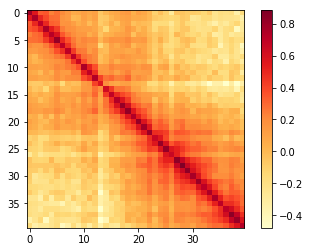

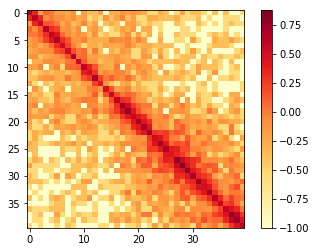

In [26]:
idx=6
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(hr_mats_test[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(lr_mats_test[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

In [82]:
import hickle as hkl
hkl.dump([hr_mats_train_scaled,lr_mats_train_scaled],'train_data.hkl')

In [44]:
sample_hr = hr_contacts_norm_dict['chr17'][7000:7100,7000:7100]
sample_lr = lr_contacts_norm_dict['chr17'][7000:7100,7000:7100]
sample_hr=sample_hr*2.0/max_hr_contact_norm['chr17']-1
sample_lr=sample_lr*2.0/max_lr_contact_norm['chr17']-1
hkl.dump(sample_hr,'test_sample_hr.hkl')
hkl.dump(sample_lr,'test_sample_lr.hkl')

In [50]:
sample_test_in = sample_lr[np.newaxis,:,np.newaxis]
sample_test_in = sample_test_in.transpose((0,1,3,2))
sample_test_in.shape

(1, 100, 100, 1)

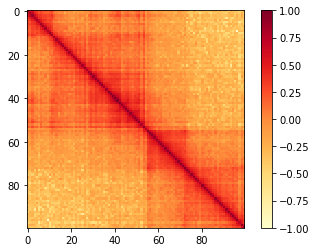

(100, 100, 1)

In [119]:
def generate_sample(chrom,start,end,is_hr=False,res=10000):
    #start,end in Mb
    if is_hr:
        hic_matrix = hr_contacts_norm_dict[chrom]
        max_contact = max_hr_contact
    else:
        hic_matrix = lr_contacts_norm_dict[chrom]
        max_contact = max_lr_contact
    def hic_normlize(mat):
        row,col = mat.shape
        mat_trans = np.log2(mat*max_contact/sum(sum(mat))+1)
        mat_trans /=0.5*mat_trans.max()
        mat_trans-=1
        return mat_trans
    #hic_matrix+= hic_matrix.T - np.diag(hic_matrix.diagonal())
    #hic_matrix = hic_normlize(hic_matrix)
    
    start_idx = start*1000000/res
    end_idx = end*1000000/res
    sample_data = hic_matrix[start_idx:end_idx,start_idx:end_idx]
    # why sample_data.max() not max_contact
    sample_data = sample_data*2.0/sample_data.max()-1
    cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
    cmap = plt.get_cmap(cmaps[3])
    plt.imshow(sample_data,cmap=cmap)
    plt.grid(False)
    plt.colorbar()
    plt.show()
    return sample_data

test_sample = generate_sample('chr17',70,71,is_hr=True,res=10000)
test_sample = test_sample[:,np.newaxis]
test_sample=test_sample.transpose((0,2,1))
test_sample.shape
    

NameError: name 'neg_g' is not defined

In [4]:
t_image = tf.placeholder('float32', [None, None, None, 1], name='image_input')
net_g = hicGAN_g(t_image, is_train=False, reuse=False)

[TL] InputLayer  hicGAN_g/in: (?, ?, ?, 1)
[TL] Conv2d hicGAN_g/n64s1/c: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d hicGAN_g/n64s1/c1/0: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGAN_g/n64s1/b1/0: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d hicGAN_g/n64s1/c2/0: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGAN_g/n64s1/b2/0: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: False
[TL] ElementwiseLayer hicGAN_g/b_residual_add/0: size: (?, ?, ?, 64) fn: add
[TL] Conv2d hicGAN_g/n64s1/c1/1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGAN_g/n64s1/b1/1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] Conv2d hicGAN_g/n64s1/c2/1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGA

[TL] [*] Load ./checkpoint_v1.1/g_hicgan_400.npz SUCCESS!


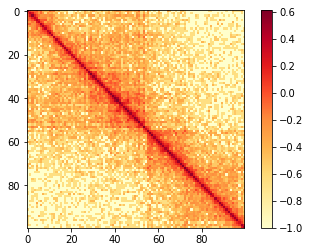

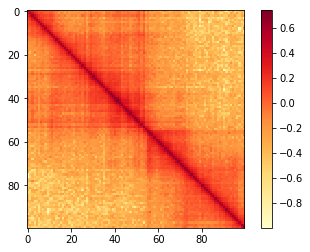

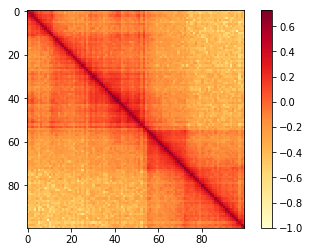

In [33]:
sample_hr = hkl.load('test_sample_hr.hkl')
sample_lr = hkl.load('test_sample_lr.hkl')
sample_test_in = sample_lr[np.newaxis,:,np.newaxis]
sample_test_in = sample_test_in.transpose((0,1,3,2))
gan_idx = 400
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
tl.layers.initialize_global_variables(sess)
tl.files.load_and_assign_npz(sess=sess, name='./checkpoint_v1.1/g_hicgan_%d.npz'%gan_idx, network=net_g)
sample_test_out = sess.run(net_g.outputs, {t_image: sample_test_in})
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(sample_test_in[0,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(sample_test_out[0,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(sample_hr,cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

In [43]:
def evaluate(gan_idx,batch=64):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
    tl.layers.initialize_global_variables(sess)
    tl.files.load_and_assign_npz(sess=sess, name='./checkpoint_v1.1/g_hicgan_%d.npz'%gan_idx, network=net_g)
    out = np.zeros(lr_mats_test.shape)
    for i in range(out.shape[0]/batch):
        out[batch*i:batch*(i+1)] = sess.run(net_g.outputs, {t_image: lr_mats_test[batch*i:batch*(i+1)]})
    out[batch*(i+1):] = sess.run(net_g.outputs, {t_image: lr_mats_test[batch*(i+1):]})
    return out


In [66]:
a=map(compare_mse,out[:,:,:,0],lr_mats_test[:,:,:,0])
len(a)
np.mean(a)
np.median(a)

5578

0.20295453475122527

0.21176355779840705

In [121]:
mse_median_list=[]
for i in range(0,3000,5):
    if i % 100==0:
        print i
    out = evaluate(i)
    mse_median_list.append(np.median(map(compare_mse,out[:,:,:,0],hr_mats_test[:,:,:,0])))
    
    
    

    

0
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_0.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_5.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_10.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_15.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_20.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_25.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_30.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_35.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_40.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_45.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_50.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_55.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_60.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_65.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_70.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_75.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_80.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1

[TL] [*] Load ./checkpoint_v1.1/g_hicgan_710.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_715.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_720.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_725.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_730.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_735.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_740.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_745.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_750.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_755.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_760.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_765.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_770.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_775.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_780.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_785.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_790.npz SUCCESS!
[TL] [*] Load 

[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1410.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1415.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1420.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1425.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1430.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1435.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1440.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1445.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1450.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1455.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1460.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1465.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1470.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1475.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1480.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1485.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_1490.npz SUCCES

[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2105.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2110.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2115.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2120.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2125.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2130.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2135.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2140.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2145.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2150.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2155.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2160.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2165.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2170.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2175.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2180.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2185.npz SUCCES

2800
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2800.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2805.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2810.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2815.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2820.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2825.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2830.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2835.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2840.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2845.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2850.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2855.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2860.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2865.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2870.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2875.npz SUCCESS!
[TL] [*] Load ./checkpoint_v1.1/g_hicgan_2880.npz S

600

(0, 0.06)

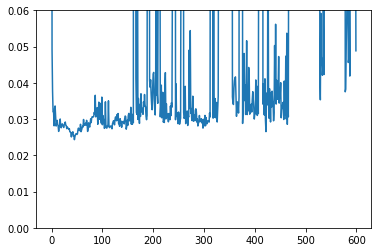

In [124]:
len(mse_median_list)
plt.plot(list(range(600)),mse_median_list)
plt.ylim(0,0.06)
plt.show()

In [125]:
mse_median_list.index(min(mse_median_list[:100]))

45

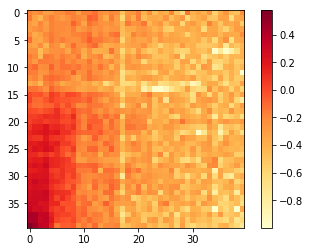

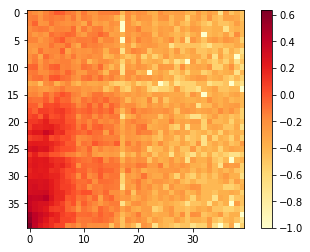

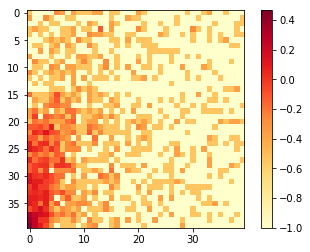

In [65]:
idx=7
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(out[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(hr_mats_test[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(lr_mats_test[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

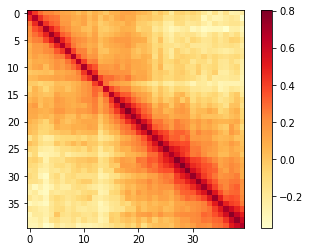

In [94]:

plt.imshow(sample_out[0,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

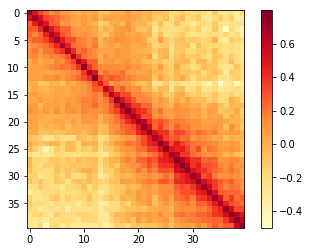

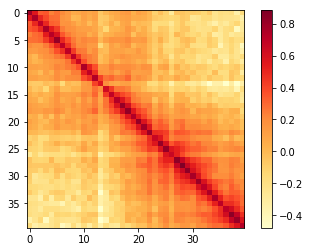

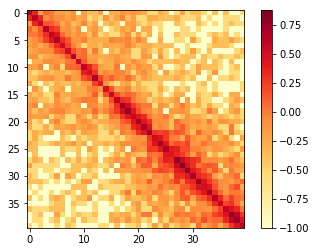

In [88]:
idx=6
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(out[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(hr_mats_test[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(lr_mats_test[idx,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

[TL] [*] Load ./checkpoint/g_hicgan_10.npz SUCCESS!


[TL] [*] Load ./checkpoint/g_hicgan_30.npz SUCCESS!


[TL] [*] Load ./checkpoint/g_hicgan_50.npz SUCCESS!


[TL] [*] Load ./checkpoint/g_hicgan_70.npz SUCCESS!


[TL] [*] Load ./checkpoint/g_hicgan_90.npz SUCCESS!


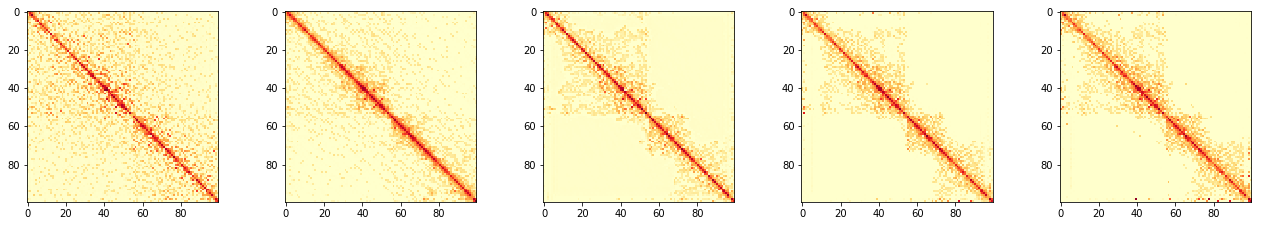

In [82]:
idx=1
plt.figure(figsize=(20, 5))
for epoch in range(10,100,20):   
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
    tl.layers.initialize_global_variables(sess)
    tl.files.load_and_assign_npz(sess=sess, name='./checkpoint/g_hicgan_%d.npz'%epoch, network=net_g)
    out = sess.run(net_g.outputs, {t_image: [test_sample]})
    cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
    cmap = plt.get_cmap(cmaps[3])
    plt.subplot(1,5,idx)
    plt.imshow(out[0,:,:,0],cmap=cmap)
    plt.grid(False)
    plt.colorbar()
    idx+=1
#
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

[TL] [*] Load ./checkpoint/g_hicgan_10.npz SUCCESS!


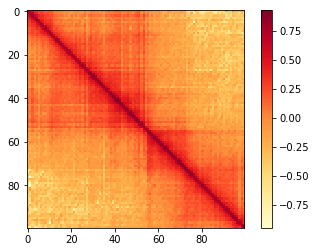

In [14]:
sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
tl.layers.initialize_global_variables(sess)
tl.files.load_and_assign_npz(sess=sess, name='./checkpoint/g_hicgan_10.npz', network=net_g)
out = sess.run(net_g.outputs, {t_image: [test_sample]})
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(out[0,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

(1, 100, 100, 1)

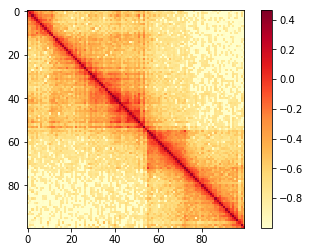

In [56]:
out.shape
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(out[0,:,:,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

In [287]:
tf.reset_default_graph()

In [278]:
#temperal for recovering previous outcome
def hicGAN_g(t_image, is_train=False, reuse=False):
    w_init = tf.random_normal_initializer(stddev=0.02)
    b_init = None  # tf.constant_initializer(value=0.0)
    g_init = tf.random_normal_initializer(1., 0.02)
    with tf.variable_scope("hicGAN_g", reuse=reuse) as vs:
        n = InputLayer(t_image, name='in')
        n = Conv2d(n, 64, (3, 3), (1, 1), act=tf.nn.relu, padding='SAME', W_init=w_init, name='n64s1/c')
        temp = n
        # B residual blocks
        for i in range(5):
            nn = Conv2d(n, 64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, b_init=b_init, name='n64s1/c1/%s' % i)
            nn = BatchNormLayer(nn, act=tf.nn.relu, is_train=is_train, gamma_init=g_init, name='n64s1/b1/%s' % i)
            nn = Conv2d(nn, 64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, b_init=b_init, name='n64s1/c2/%s' % i)
            nn = BatchNormLayer(nn, is_train=is_train, gamma_init=g_init, name='n64s1/b2/%s' % i)
            nn = ElementwiseLayer([n, nn], tf.add, name='b_residual_add/%s' % i)
            n = nn

        n = Conv2d(n, 64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, b_init=b_init, name='n64s1/c/m')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n64s1/b/m')
        n = ElementwiseLayer([n, temp], tf.add, name='add3')
        # B residual blacks end. output shape: (None,w,h,64)

        n = Conv2d(n, 256, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, name='n256s1/1')
        #n = SubpixelConv2d(n, scale=2, n_out_channel=None, act=tf.nn.relu, name='pixelshufflerx2/1')

        n = Conv2d(n, 256, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, name='n256s1/2')
        #n = SubpixelConv2d(n, scale=2, n_out_channel=None, act=tf.nn.relu, name='pixelshufflerx2/2')

        n = Conv2d(n, 1, (1, 1), (1, 1), act=tf.nn.tanh, padding='SAME', W_init=w_init, name='out')
        return n
    
    
def hicGAN_d(t_image, is_train=False, reuse=False):
    w_init = tf.random_normal_initializer(stddev=0.02)
    b_init = None
    g_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x: tl.act.lrelu(x, 0.2)
    with tf.variable_scope("hicGAN_d", reuse=reuse) as vs:
        n = InputLayer(t_image, name='in')
        n = Conv2d(n, 64, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, name='n64s1/c')

        n = Conv2d(n, 64, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n64s2/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n64s2/b')
        #output shape: (None,w/2,h/2,64)
        n = Conv2d(n, 128, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n128s1/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n128s1/b')

        n = Conv2d(n, 128, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n128s2/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n128s2/b')
        #output shape: (None,w/4,h/4,64)
        n = Conv2d(n, 256, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n256s1/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n256s1/b')

        n = Conv2d(n, 256, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n256s2/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n256s2/b')
        #output shape: (None,w/8,h/8,256)
        n = Conv2d(n, 512, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n512s1/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n512s1/b')

        n = Conv2d(n, 512, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n512s2/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n512s2/b')
        #output shape: (None,w/16,h/16,512)
        n = FlattenLayer(n, name='f')
        n = DenseLayer(n, n_units=1024, act=lrelu, name='d1024')
        n = DenseLayer(n, n_units=1, name='out')

        logits = n.outputs
        n.outputs = tf.nn.sigmoid(n.outputs)

        return n, logits

In [3]:
def hicGAN_g(t_image, is_train=False, reuse=False):
    w_init = tf.random_normal_initializer(stddev=0.02)
    b_init = None  # tf.constant_initializer(value=0.0)
    g_init = tf.random_normal_initializer(1., 0.02)
    with tf.variable_scope("hicGAN_g", reuse=reuse) as vs:
        n = InputLayer(t_image, name='in')
        n = Conv2d(n, 64, (3, 3), (1, 1), act=tf.nn.relu, padding='SAME', W_init=w_init, name='n64s1/c')
        temp = n
        # B residual blocks
        for i in range(3):
            nn = Conv2d(n, 64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, b_init=b_init, name='n64s1/c1/%s' % i)
            nn = BatchNormLayer(nn, act=tf.nn.relu, is_train=is_train, gamma_init=g_init, name='n64s1/b1/%s' % i)
            nn = Conv2d(nn, 64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, b_init=b_init, name='n64s1/c2/%s' % i)
            nn = BatchNormLayer(nn, is_train=is_train, gamma_init=g_init, name='n64s1/b2/%s' % i)
            nn = ElementwiseLayer([n, nn], tf.add, name='b_residual_add/%s' % i)
            n = nn

        n = Conv2d(n, 64, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, b_init=b_init, name='n64s1/c/m')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n64s1/b/m')
        n = ElementwiseLayer([n, temp], tf.add, name='add3')
        # B residual blacks end. output shape: (None,w,h,64)

        n = Conv2d(n, 128, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, name='n256s1/1')
        #n = SubpixelConv2d(n, scale=2, n_out_channel=None, act=tf.nn.relu, name='pixelshufflerx2/1')

        #n = Conv2d(n, 256, (3, 3), (1, 1), act=None, padding='SAME', W_init=w_init, name='n256s1/2')
        #n = SubpixelConv2d(n, scale=2, n_out_channel=None, act=tf.nn.relu, name='pixelshufflerx2/2')

        n = Conv2d(n, 1, (1, 1), (1, 1), act=tf.nn.tanh, padding='SAME', W_init=w_init, name='out')
        return n
    
    
def hicGAN_d(t_image, is_train=False, reuse=False):
    w_init = tf.random_normal_initializer(stddev=0.02)
    b_init = None
    g_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x: tl.act.lrelu(x, 0.2)
    with tf.variable_scope("hicGAN_d", reuse=reuse) as vs:
        n = InputLayer(t_image, name='in')
        n = Conv2d(n, 64, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, name='n64s1/c')

        n = Conv2d(n, 64, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n64s2/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n64s2/b')
        #output shape: (None,w/2,h/2,64)
        n = Conv2d(n, 128, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n128s1/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n128s1/b')

        n = Conv2d(n, 128, (3, 3), (4, 4), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n128s2/c')
        n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n128s2/b')
        #output shape: (None,w/4,h/4,64)
        #n = Conv2d(n, 256, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n256s1/c')
        #n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n256s1/b')

        #n = Conv2d(n, 256, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n256s2/c')
        #n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n256s2/b')
        #output shape: (None,w/8,h/8,256)
        #n = Conv2d(n, 512, (3, 3), (1, 1), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n512s1/c')
        #n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n512s1/b')

        #n = Conv2d(n, 512, (3, 3), (2, 2), act=lrelu, padding='SAME', W_init=w_init, b_init=b_init, name='n512s2/c')
        #n = BatchNormLayer(n, is_train=is_train, gamma_init=g_init, name='n512s2/b')
        #output shape: (None,w/16,h/16,512)
        n = FlattenLayer(n, name='f')
        n = DenseLayer(n, n_units=1024, act=lrelu, name='d1024')
        n = DenseLayer(n, n_units=1, name='out')

        logits = n.outputs
        n.outputs = tf.nn.sigmoid(n.outputs)

        return n, logits

In [261]:
t_image = tf.placeholder('float32', [batch_size, 40, 40, 1], name='input_to_generator')
t_target_image = tf.placeholder('float32', [batch_size, 40, 40, 1], name='t_target_hic_image')

net_g = hicGAN_g(t_image, is_train=True, reuse=True)
net_d, logits_real = hicGAN_d(t_target_image, is_train=True, reuse=True)
_, logits_fake = hicGAN_d(net_g.outputs, is_train=True, reuse=True)

net_g_test = hicGAN_g(t_image, is_train=False, reuse=True)
d_loss1 = tl.cost.sigmoid_cross_entropy(logits_real, tf.ones_like(logits_real), name='d1')
d_loss2 = tl.cost.sigmoid_cross_entropy(logits_fake, tf.zeros_like(logits_fake), name='d2')
d_loss = d_loss1 + d_loss2
g_gan_loss = 1e-3 * tl.cost.sigmoid_cross_entropy(logits_fake, tf.ones_like(logits_fake), name='g')
mse_loss = tl.cost.mean_squared_error(net_g.outputs, t_target_image, is_mean=True)
g_loss = mse_loss + g_gan_loss
g_vars = tl.layers.get_variables_with_name('hicGAN_g', True, True)
d_vars = tl.layers.get_variables_with_name('hicGAN_d', True, True)

with tf.variable_scope('learning_rate'):
    lr_v = tf.Variable(lr_init, trainable=False)

g_optim_init = tf.train.AdamOptimizer(lr_v, beta1=beta1).minimize(mse_loss, var_list=g_vars)
g_optim = tf.train.AdamOptimizer(lr_v, beta1=beta1).minimize(g_loss, var_list=g_vars)
d_optim = tf.train.AdamOptimizer(lr_v, beta1=beta1).minimize(d_loss, var_list=d_vars)

[TL] InputLayer  hicGAN_g/in: (16, 40, 40, 1)
[TL] Conv2d hicGAN_g/n64s1/c: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: relu
[TL] Conv2d hicGAN_g/n64s1/c1/0: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGAN_g/n64s1/b1/0: decay: 0.900000 epsilon: 0.000010 act: relu is_train: True
[TL] Conv2d hicGAN_g/n64s1/c2/0: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGAN_g/n64s1/b2/0: decay: 0.900000 epsilon: 0.000010 act: No Activation is_train: True
[TL] ElementwiseLayer hicGAN_g/b_residual_add/0: size: (16, 40, 40, 64) fn: add
[TL] Conv2d hicGAN_g/n64s1/c1/1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hicGAN_g/n64s1/b1/1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: True
[TL] Conv2d hicGAN_g/n64s1/c2/1: n_filter: 64 filter_size: (3, 3) strides: (1, 1) pad: SAME act: No Activation
[TL] BatchNormLayer hi

ValueError: Variable hicGAN_g/n64s1/c1/3/kernel does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

# Evaluation and Comparison

In [5]:
from skimage.measure import compare_ssim
from skimage.measure import compare_mse
from skimage.measure import compare_psnr

In [10]:
lr_mats_test,hr_mats_test,distance_all=hkl.load('./GM12878_primary/test_data_log_trans_scaled_sym.hkl')

In [8]:
def evaluate(gan_idx,batch=64):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=False))
    tl.layers.initialize_global_variables(sess)
    tl.files.load_and_assign_npz(sess=sess, name='./checkpoint_easy/g_hicgan_%d.npz'%gan_idx, network=net_g)
    out = np.zeros(lr_mats_test.shape)
    for i in range(out.shape[0]/batch):
        out[batch*i:batch*(i+1)] = sess.run(net_g.outputs, {t_image: lr_mats_test[batch*i:batch*(i+1)]})
    out[batch*(i+1):] = sess.run(net_g.outputs, {t_image: lr_mats_test[batch*(i+1):]})
    return out
sr_mats_pre = evaluate(300)

[TL] [*] Load ./checkpoint_easy/g_hicgan_300.npz SUCCESS!


In [11]:
#transform from norm to reads count
def trans_norm2readscount_hr(chrom,mat):
    max_hr_contact = max([nb_hr_contacts[item] for item in nb_hr_contacts.keys()])
    mat_hat=(mat+1)*0.5*max_hr_contact_norm[chrom]
    return (np.exp2(mat_hat)-1)*nb_hr_contacts[chrom]/max_hr_contact
    
max_hr_contact_norm = hkl.load('./GM12878_primary/max_hr_contact_norm.hkl')
max_lr_contact_norm = hkl.load('./GM12878_primary/max_lr_contact_norm.hkl')
nb_hr_contacts = hkl.load('./GM12878_primary/nb_hr_contacts.hkl')
nb_lr_contacts = hkl.load('./GM12878_primary/nb_lr_contacts.hkl')
chrom_list=[item[1] for item in distance_all]
sr_mats_pre_readscount=map(trans_norm2readscount_hr,chrom_list,sr_mats_pre[:,:,:,0])
#for validation there is nothing wrong, compare hr_mats_test_readscount and hr_mats_test from test_data_raw_count.hkl
#they should be exactly the same
#hr_mats_test_readscount=map(trans_norm2readscount_hr,chrom_list,hr_mats_test[:,:,:,0])


In [12]:
_,hr_mats_test_readscount,_ = hkl.load('./GM12878_primary/test_data_raw_count.hkl')

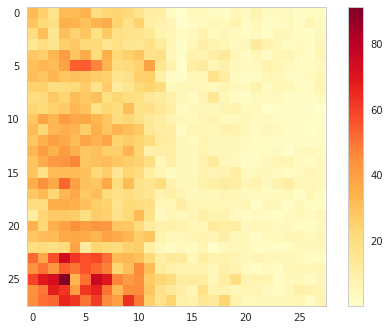

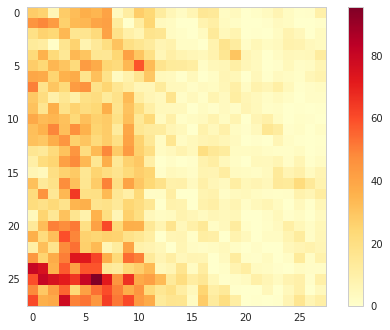

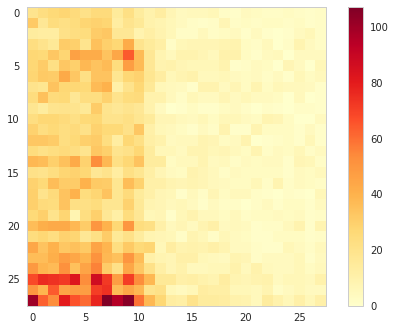

In [217]:
idx=40
cmaps = ['Greys','Reds','YlOrBr','YlOrRd','hot']
cmap = plt.get_cmap(cmaps[3])
plt.imshow(sr_mats_pre_readscount[idx][6:34,6:34],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(Y_pre[idx],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()
plt.imshow(hr_mats_test_readscount[idx,6:34,6:34,0],cmap=cmap)
plt.grid(False)
plt.colorbar()
plt.show()

In [254]:
#hr_mats_test_readscount=hr_mats_test_readscount.astype('float64')
np.max(sr_mats_pre_readscount)
np.max(hr_mats_test_readscount)
np.min(sr_mats_pre_readscount)
np.min(hr_mats_test_readscount)

3215.147507253413

5137.0

0.0

0.0

In [13]:
def calculate_psnr(mat1,mat2):
    data_range=np.max(mat1)-np.min(mat1)
    err=compare_mse(mat1,mat2)
    return 10 * np.log10((data_range ** 2) / err)
def calculate_ssim(mat1,mat2):
    data_range=np.max(mat1)-np.min(mat1)
    return compare_ssim(mat1,mat2,data_range=data_range)

In [14]:
mse_hicGAN_norm=map(compare_mse,hr_mats_test[:,:,:,0],sr_mats_pre[:,:,:,0])
psnr_hicGAN_norm=map(calculate_psnr,hr_mats_test[:,:,:,0],sr_mats_pre[:,:,:,0])
ssim_hicGAN_norm=map(calculate_ssim,hr_mats_test[:,:,:,0],sr_mats_pre[:,:,:,0])
np.median(mse_hicGAN_norm)
np.median(psnr_hicGAN_norm)
np.median(ssim_hicGAN_norm)

0.031524656390000017

15.165395256803713

0.2114983329061766

In [301]:
mse_hicGAN=map(compare_mse,hr_mats_test_readscount[:,:,:,0],sr_mats_pre_readscount)
psnr_hicGAN=map(calculate_psnr,hr_mats_test_readscount[:,:,:,0],sr_mats_pre_readscount)
ssim_hicGAN=map(calculate_ssim,hr_mats_test_readscount[:,:,:,0],sr_mats_pre_readscount)
np.median(mse_hicGAN)
np.median(psnr_hicGAN)
np.median(ssim_hicGAN)

18.92418488956922

16.972512668165628

0.23878203226551947

In [165]:
#best so far
mse_hicGAN=map(compare_mse,hr_mats_test_readscount[:,:,:,0],sr_mats_pre_readscount)
psnr_hicGAN=map(calculate_psnr,hr_mats_test_readscount[:,:,:,0],sr_mats_pre_readscount)
ssim_hicGAN=map(calculate_ssim,hr_mats_test_readscount[:,:,:,0],sr_mats_pre_readscount)
np.median(mse_hicGAN)
np.median(psnr_hicGAN)
np.median(ssim_hicGAN)

16.367188848878897

17.730949271285937

0.27520744028037347

In [118]:
#load hicPlus data
Y_test_crop,Y_pre = hkl.load('./GM12878_primary/hicPlus_pre.hkl')

In [166]:
mse_hicPlus=map(compare_mse,Y_test_crop,Y_pre)
psnr_hicPlus=map(calculate_psnr,Y_test_crop,Y_pre)
ssim_hicPlus=map(calculate_ssim,Y_test_crop,Y_pre)
np.median(mse_hicPlus)
np.median(psnr_hicPlus)
np.median(ssim_hicPlus)

25.869742942854582

13.317420576092731

0.28485226247188344

In [173]:
ind_0,ind_40,ind_80,ind_120,ind_160=[],[],[],[],[]
for i in range(len(distance_all)):
    if abs(distance_all[i][0])==0:
        ind_0.append(i)
    elif abs(distance_all[i][0])==40:
        ind_40.append(i)
    elif abs(distance_all[i][0])==80:
        ind_80.append(i)
    elif abs(distance_all[i][0])==120:
        ind_120.append(i)
    elif abs(distance_all[i][0])==160:
        ind_160.append(i)
    else:
        print 'error'

In [180]:
np.max(mse_hicGAN)
np.max(mse_hicPlus)

21534.73058098359

5503.80604091826

In [247]:
data_mse_hicGAN = [np.array(mse_hicGAN)[ind_0],np.array(mse_hicGAN)[ind_40],np.array(mse_hicGAN)[ind_80],np.array(mse_hicGAN)[ind_120],np.array(mse_hicGAN)[ind_160]]
data_ssim_hicGAN = [np.array(psnr_hicGAN)[ind_0],np.array(psnr_hicGAN)[ind_40],np.array(psnr_hicGAN)[ind_80],np.array(psnr_hicGAN)[ind_120],np.array(psnr_hicGAN)[ind_160]]
data_psnr_hicGAN = [np.array(ssim_hicGAN)[ind_0],np.array(ssim_hicGAN)[ind_40],np.array(ssim_hicGAN)[ind_80],np.array(ssim_hicGAN)[ind_120],np.array(ssim_hicGAN)[ind_160]]

In [303]:
data_mse_hicGAN_norm = [np.array(mse_hicGAN_norm)[ind_0],np.array(mse_hicGAN_norm)[ind_40],np.array(mse_hicGAN_norm)[ind_80],np.array(mse_hicGAN_norm)[ind_120],np.array(mse_hicGAN_norm)[ind_160]]
data_ssim_hicGAN_norm = [np.array(psnr_hicGAN_norm)[ind_0],np.array(psnr_hicGAN_norm)[ind_40],np.array(psnr_hicGAN_norm)[ind_80],np.array(psnr_hicGAN_norm)[ind_120],np.array(psnr_hicGAN_norm)[ind_160]]
data_psnr_hicGAN_norm = [np.array(ssim_hicGAN_norm)[ind_0],np.array(ssim_hicGAN_norm)[ind_40],np.array(ssim_hicGAN_norm)[ind_80],np.array(ssim_hicGAN_norm)[ind_120],np.array(ssim_hicGAN_norm)[ind_160]]

In [181]:
data_mse_hicPlus = [np.array(mse_hicPlus)[ind_0],np.array(mse_hicPlus)[ind_40],np.array(mse_hicPlus)[ind_80],np.array(mse_hicPlus)[ind_120],np.array(mse_hicPlus)[ind_160]]
data_ssim_hicPlus = [np.array(psnr_hicPlus)[ind_0],np.array(psnr_hicPlus)[ind_40],np.array(psnr_hicPlus)[ind_80],np.array(psnr_hicPlus)[ind_120],np.array(psnr_hicPlus)[ind_160]]
data_psnr_hicPlus = [np.array(ssim_hicPlus)[ind_0],np.array(ssim_hicPlus)[ind_40],np.array(ssim_hicPlus)[ind_80],np.array(ssim_hicPlus)[ind_120],np.array(ssim_hicPlus)[ind_160]]

{'boxes': [<matplotlib.lines.Line2D at 0x7f0e98a56410>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0e98a56c50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f0e989fa7d0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f0e989fa410>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f0e98a564d0>,
  <matplotlib.lines.Line2D at 0x7f0e989be350>]}

Text(0.5,1,u'MSE')

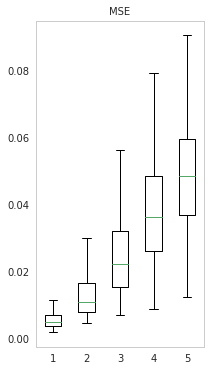

In [236]:
import seaborn as sns
sns.set_style("whitegrid")  # 白色网格背景
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(3, 6), sharey=True)
axes.grid(False)
axes.boxplot(data_mse_hicGAN_norm)
axes.set_title('MSE', fontsize=10)
# axes[1].boxplot(data_ssim)
# axes[1].set_title('SSIM', fontsize=10)
# axes[2].boxplot(data_psnr)
# axes[2].set_title('PSNR', fontsize=10)
#plt.savefig('boxplot_psnr.pdf')
plt.show()

In [191]:
a=np.array([[1,2],[3,4]])
a
a.diagonal(offset=-1)
a.diagonal(offset=1)

array([[1, 2],
       [3, 4]])

array([3])

array([2])

In [248]:
dic={}
for i in range(200):
    dic[i]=[[],[]]#true and pre
for i in range(len(distance_all)):
    for j in range(-39,40,1):
        dis = distance_all[i][0]-j
        dic[abs(dis)][0]+=hr_mats_test_readscount[i,:,:,0].diagonal(offset=j).tolist()
        dic[abs(dis)][1]+=sr_mats_pre_readscount[i].diagonal(offset=j).tolist()

In [304]:
dic_norm={}
for i in range(200):
    dic_norm[i]=[[],[]]#true and pre
for i in range(len(distance_all)):
    for j in range(-39,40,1):
        dis = distance_all[i][0]-j
        dic_norm[abs(dis)][0]+=hr_mats_test[i,:,:,0].diagonal(offset=j).tolist()
        dic_norm[abs(dis)][1]+=sr_mats_pre[i,:,:,0].diagonal(offset=j).tolist()

In [227]:
dic_hicPlus={}
for i in range(200):
    dic_hicPlus[i]=[[],[]]#true and pre
for i in range(len(distance_all)):
    for j in range(-27,28,1):
        dis = distance_all[i][0]-j
        dic_hicPlus[abs(dis)][0]+=Y_test_crop[i].diagonal(offset=j).tolist()
        dic_hicPlus[abs(dis)][1]+=Y_pre[i].diagonal(offset=j).tolist()

In [155]:
dic={}
for i in range(200):
    dic[i]=[[],[]]#true and pre
for i in range(sr_mats_pre_readscount.shape[0]):
    for ii in range(40):
        for jj in range(40):
            dis = distance_all[i][0]+ii-jj
            if out[i][ii][jj][0]==0 and dis==0:
                print i,ii,jj
                sys.exit()
            dic[abs(dis)][0].append(hr_mats_test[i][ii][jj][0])
            dic[abs(dis)][1].append(lr_mats_test[i][ii][jj][0])
    

In [194]:
scipy.stats.pearsonr(dic[1][0],dic[1][1])

(0.9386172095542112, 0.0)

In [156]:
scipy.stats.pearsonr(dic[1][0],dic[1][1])

(0.9806626049349695, 0.0)

In [305]:
y=[]
y_norm=[]
y_hicPlus=[]
for i in range(200):
    y.append(scipy.stats.pearsonr(dic[i][0],dic[i][1])[0])
    y_norm.append(scipy.stats.pearsonr(dic_norm[i][0],dic_norm[i][1])[0])
    y_hicPlus.append(scipy.stats.pearsonr(dic_hicPlus[i][0],dic_hicPlus[i][1])[0])
    
    

In [220]:
for i in range(200):
    print i,y[i]

0 0.9175817572349901
1 0.9386172095542112
2 0.940545573502152
3 0.9442855078069214
4 0.9429679212953898
5 0.9397810465026735
6 0.9421940177830774
7 0.9397155628655178
8 0.9394574545468051
9 0.9383925783250733
10 0.9394657985170514
11 0.9350417085622663
12 0.9331936289298125
13 0.9336866189524194
14 0.9318235470037355
15 0.928528689443862
16 0.9271185090888217
17 0.9247042440360209
18 0.9246519669135078
19 0.9238055519473083
20 0.9181639269943156
21 0.9182705036123935
22 0.914205878261441
23 0.9111546634404531
24 0.9060408247864888
25 0.8997837813642419
26 0.8983671813147572
27 0.8924675255264448
28 0.8839212992560348
29 0.8799032226605249
30 0.8694962030477065
31 0.861453949271726
32 0.8499662398547235
33 0.843992818848518
34 0.8356872342441819
35 0.8353858478338005
36 0.8393678962305647
37 0.8446773683949035
38 0.8488824310551732
39 0.8436473481086161
40 0.8461584835815461
41 0.8609089740607095
42 0.8637896202756095
43 0.8678998340423982
44 0.871421560459674
45 0.8759360238709623
46 0

In [159]:
y_low[:10]
y[:10]

[0.9928730956673579,
 0.9806626049349695,
 0.9593037614923982,
 0.9349836090471172,
 0.911518068672931,
 0.8926379923590532,
 0.8708091325604917,
 0.8543951849676105,
 0.8350257801105727,
 0.8224163742401144]

[0.9900924493815453,
 0.9898480078900854,
 0.9885496715668961,
 0.9874297284385198,
 0.9852827989894609,
 0.9850578404489433,
 0.9834741360571855,
 0.9819125089912305,
 0.980683206341195,
 0.9794934716616951]

(0, 1)

Text(0.5,0,u'genomic distance(10kb)')

Text(0,0.5,u'Pearson r')

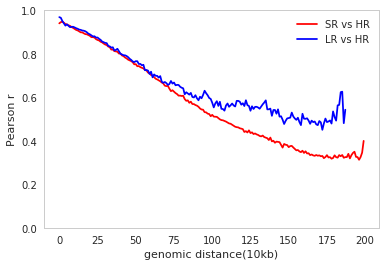

In [306]:
sns.set_style("whitegrid")  # 白色网格背景
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
axes.grid(False)
axes.plot(list(range(200)),y_norm,'r',label='SR vs HR')
axes.plot(list(range(200)),y_hicPlus,'b',label='LR vs HR')
plt.ylim(0,1)
#plt.ylim(0,100)
plt.xlabel('genomic distance(10kb)')
plt.ylabel('Pearson r')
#plt.xlim(0,120)
plt.legend()
plt.show()

(0, 1)

Text(0.5,0,u'genomic distance(10kb)')

Text(0,0.5,u'Pearson r')

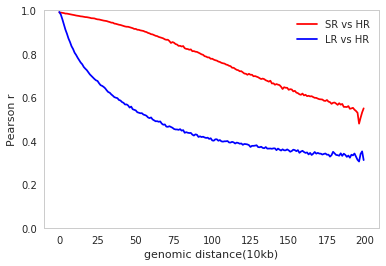

In [179]:
sns.set_style("whitegrid")  # 白色网格背景
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
axes.grid(False)
axes.plot(list(range(200)),y,'r',label='SR vs HR')
#axes.plot(x,y_low,'b',label='LR vs HR')
plt.ylim(0,1)
#plt.ylim(0,100)
plt.xlabel('genomic distance(10kb)')
plt.ylabel('Pearson r')
plt.legend()
plt.show()

(0, 1)

Text(0.5,0,u'genomic distance(10kb)')

Text(0,0.5,u'Pearson r')

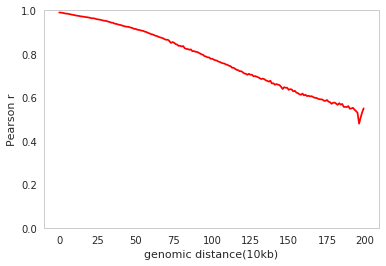

In [160]:
sns.set_style("whitegrid")  # 白色网格背景
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharey=True)
axes.grid(False)
axes.plot(x,y,'r')
plt.ylim(0,1)
#plt.ylim(0,100)
plt.xlabel('genomic distance(10kb)')
plt.ylabel('Pearson r')
plt.show()